## Clustering Analyisis 

In this notebook I analyse the 2 point correlation function of the three HSB samples and compare them to that of the LSB sample.

In each case the errors are estimated using the jackknife approach; For $N$ jackknife resamplings, the estimation of the covariance is:

\begin{equation}
C_{ij} = \frac{N-1}{N} \sum_{k=1}^N (x_i^k - \bar{x}_i)(x_j^k - \bar{x}_j)
\end{equation}

where:

\begin{equation}
\bar{x}_i = \frac{1}{N}\sum_{k=1}^N x_i^k
\end{equation}


### Improvements compared to the previous notebook

In the present notebook there are a few differences compared to previous notebooks in the calculation of the 2pt function of the HSB galaxy sample.


- First, we exclude galaxies with "weird" photo-z values. By "weird" values, we mean any negative photo-z (either in the mean or the mc value) and we also exclude cases where the mean and the mc values differ by a lot.

- Then, we select a sub-sample with the same $g$-magnitude distribution as the low surface brightness galaxies.

- Finally, by applying photo-z cuts ($z < z_p$) we try to select samples that: 

    i) The 2pt auto-correlation of the HSB galaxies is as close as possible to that of the LSB galaxies (visually)
    
    ii) The cross-correlation between the HSB galaxies and the LSB galaxies is maximized. 

In [1]:
#Import stuff
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
#import seaborn as sns
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    # if you have LaTeX installed on your laptop, uncomment the line below for prettier labels
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

In [2]:
import treecorr
import healpy as hp
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord

### Write a function that calculates Jackknife errors, given a data catalog and a random catalog

In [4]:
def Jackknife(ra_dat, dec_dat, ra_rand, dec_rand, N_samples):
    """
    Inputs
    ------------------------------------------
    ra_dat: the ra of the data catalog
    dec_dat: the dec of the data catalog
     
    ra_rand: the ra of the random catalog
    dec_rand: the dac of the random catalog
    
    Outputs
    ------------------------------------------
    Errors in the two-point calculation across different scales
    """
    
    # First of all create array to store the results of the evaluations of 
    # the two point correlation functions
    Xi_vect = np.zeros([N_samples,20]) 
    
    #Create array with length equal to the length of the sample and entries 0,1,...,len(sample)
    len_smpl = len(ra_dat) #length of the sample
    
    A = np.arange(len_smpl)
    #Create array where you randomly redistribute these 
    np.random.shuffle(A)
    
    #randomize the distribution of the ra, dec vectors of the data
    ra_dat_rn = ra_dat[A]
    dec_dat_rn = dec_dat[A]
    
    # Batch size
    batch = int(len_smpl/N_samples)
    
    # =====================================================================
    # =====================================================================
    
    # Let's make a catalog for the randoms
    rand = treecorr.Catalog(ra=ra_rand, dec=dec_rand, ra_units='radians', dec_units='radians')
    rr = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
    rr.process(rand)
    
    # =====================================================================
    # =====================================================================
    #Populate the Xi_vect
    for i in range(N_samples):
        # Points to keep
        init = i*batch #Initial points not to keep
        fin = (i+1)*batch #final points not to keep
        
        # Keep data where you have excluded one batch 
        ra_dat_loc = np.concatenate((ra_dat_rn[:init],ra_dat_rn[fin:]))
        dec_dat_loc = np.concatenate((dec_dat_rn[:init],dec_dat_rn[fin:]))
        
        # Create catalog using the above data 
        cat_dat_loc = treecorr.Catalog(ra=ra_dat_loc, dec=dec_dat_loc, ra_units='deg', dec_units='deg')
        dd_loc = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
        dd_loc.process(cat_dat_loc)
        
        #data - random catalog
        dr_loc = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
        dr_loc.process(cat_dat_loc, rand)
        
        # Calculate 2pt correlation function of the sample
        xi_loc, varxi_loc = dd_loc.calculateXi(rr, dr_loc)
        
        Xi_vect[i,:] = xi_loc
    
        
    # ======================================================================
    # ======================================================================
    # Define vector to store the errors
    Err_vect = np.zeros(20)
    
    for i in range(20):
        
        Xi_i = Xi_vect[:,i]
        mean_Xi_i = np.mean(Xi_i)
        diff_sq = (Xi_i - mean_Xi_i)**2.0
        sig_sq = ((N_samples - 1.0)/N_samples)*np.sum(diff_sq)

        Err_vect[i] = np.sqrt(sig_sq)
    
    return Err_vect  

### Define a function that calculate 2pt auto-correlation of a sample

Here we define a function that takes as inputs the coordinates of a data catalog and of a random catalog and returns the auto-correlation function (xi) and the angular points where it is being evaluated (r).

In [5]:
def auto_correlation(ra_dat, dec_dat, ra_rand, dec_rand):
    """
    Inputs
    ------------------------------------------
    ra_dat: the ra of the data catalog
    dec_dat: the dec of the data catalog
     
    ra_rand: the ra of the random catalog
    dec_rand: the dac of the random catalog
    
    Outputs
    ------------------------------------------
    Errors in the two-point calculation across different scales
    """
    # Create catalog for the data
    cat_dat = treecorr.Catalog(ra=ra_dat, dec=dec_dat, ra_units='deg', dec_units='deg')
    dd = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
    dd.process(cat_dat)
    
    # Let's make a catalog for the randoms
    cat_rand = treecorr.Catalog(ra=ra_rand, dec=dec_rand, ra_units='radians', dec_units='radians')
    rr = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
    rr.process(cat_rand)
    
    # Let's also create their cross catalog
    # ===========================================================
    dr = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
    dr.process(cat_dat, rand)
    # ===========================================================
    # Calculate 2pt correlation function of the total sample
    xi, varxi = dd.calculateXi(rr, dr)
    r = np.exp(dd.meanlogr)
    
    return r, xi

###  Create a random catalog - it will be useful anyway

In [6]:
# Open MAP 
# ==========================================
MAP = hp.read_map('y3a2_footprint_grizY_any.fits')

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


Create a random catalog that covers the footprint.

In [7]:
conv = np.pi/180.
ra_min = -70.0*conv
ra_max = 110.*conv
dec_min = -70.*conv
dec_max = 10.*conv
# ========================
# ========================
rand_ra = np.random.uniform(ra_min, ra_max, 10**7)
rand_sindec = np.random.uniform(np.sin(dec_min), np.sin(dec_max), 10**7)
rand_dec = np.arcsin(rand_sindec)
# ========================

In [8]:
# Get the healpix indices of the randoms
HP_ind_rand = hp.ang2pix(4096, rand_ra/conv, rand_dec/conv, lonlat=True)

In [9]:
# Get a mask - 1 inside the DES mask
DES_mask = np.zeros(len(MAP))
DES_mask[MAP>0] = 1
# =====================================
# =====================================

In [10]:
# Keep only those with randoms for which the value of the des mask 
# ===============================================
# ===============================================
# Keep local mask
LOCAL_mask_rand = DES_mask[HP_ind_rand]

# Keep those with LOCAL_mask = 1
rand_ra_pos = rand_ra[LOCAL_mask_rand==1]
rand_dec_pos = rand_dec[LOCAL_mask_rand==1]

In [11]:
# Let's make a catalog for the randoms
rand = treecorr.Catalog(ra=rand_ra_pos, dec=rand_dec_pos, ra_units='radians', dec_units='radians')
rr = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
rr.process(rand)

### Import the LSB and HSB  catalogs

#### - Import the LSB catalog

In [12]:
#from astropy.io import fits
#Galfit_res = fits.open('y3_gold_2_2_lsbg_galfit_v3.2.fits')
#Galfit_res = fits.open('Galfit_final_IDs.fits')

# Coordinates
#ra = Galfit_res[1].data["RA"]
#dec = Galfit_res[1].data["DEC"]

#flux_rad_g = Galfit_res[1].data["FLUX_RADIUS_G"]
#flux_rad_r = Galfit_res[1].data["FLUX_RADIUS_R"]
#flux_rad_i = Galfit_res[1].data["FLUX_RADIUS_I"]

# Load the magnitudes to calculate colors
#mag_g = Galfit_res[1].data["MAG_G"]
#mag_r = Galfit_res[1].data["MAG_R"]
#mag_i = Galfit_res[1].data["MAG_I"]

#z_mean_lsb = 
#z_mc_lsb = 

# Import (and plot for visualization reasons) the coordinates of the LSBGs objects
ra, dec= np.loadtxt("LSBGs_properties_tot.dat", usecols=(1,2), unpack=3)
flux_rad_g = np.loadtxt("LSBGs_properties_tot.dat", usecols=(6), unpack=3)
# Load the magnitudes to calculate colors
mag_g, mag_r, mag_i = np.loadtxt("LSBGs_properties_tot.dat", usecols=(5,11,17), unpack=3)
z_mean_lsb, z_mc_lsb = np.loadtxt("LSBGs_properties_tot.dat", usecols=(23,24), unpack=3)

# Define the colors here
col_g_i = mag_g - mag_i
col_g_r = mag_g - mag_r
col_i_r = mag_i - mag_r
# ==================================================================
# ==================================================================
for i in range(len(ra)):
    if (ra[i] > 150.):
        ra[i] = ra[i]-360.       

#### - Import the HSB catalog

In [13]:
# Open and read the HSB galaxies catalog
HSB_gal = fits.open('HSB_3.fits')
# ===============================================================
# ===============================================================
#print HSB_gal[1].header.keys
ra_HSB = HSB_gal[1].data['RA']
dec_HSB = HSB_gal[1].data['DEC']
Z_MEAN_HSB = HSB_gal[1].data['DNF_ZMEAN_MOF']
Z_MC_HSB = HSB_gal[1].data['DNF_ZMC_MOF']
MU_MEAN_G_HSB = HSB_gal[1].data['MU_MEAN_MODEL_G']
mag_i_HSB = HSB_gal[1].data['MAG_AUTO_I']
mag_g_HSB = HSB_gal[1].data['MAG_AUTO_G']
col_g_i_HSB = mag_g_HSB - mag_i_HSB

for i in range(len(ra_HSB)):
    if (ra_HSB[i] > 150.):
        ra_HSB[i] = ra_HSB[i]-360.
        
#HSB_gal[1].header.keys

### Import the 2MPZ catalog

In [14]:
# Open and read the 2MPZ catalog
mpz_cat = fits.open('2MPZ.fits')
#mpz_cat[1].header.keys

# Convert to rad 
rad_to_deg = 180.0/np.pi
ra_mpz = rad_to_deg*mpz_cat[1].data['RA']
dec_mpz = rad_to_deg*mpz_cat[1].data['DEC']
z_mpz = mpz_cat[1].data['ZPHOTO']

for i in range(len(ra_mpz)):
    if (ra_mpz[i] > 150.):
        ra_mpz[i] = ra_mpz[i]-360.
        
# Keep only those in the box (-70,110)&(-70,10)
box = (ra_mpz>-70.0)&(ra_mpz<110.)&(dec_mpz>-70.0)&(dec_mpz<10.0)

ra_mpz = ra_mpz[box]
dec_mpz = dec_mpz[box]
z_mpz = z_mpz[box]

# ===============================================
# ===============================================
# keep those with z<0.11

ra_mpz = ra_mpz[z_mpz<0.10]
dec_mpz = dec_mpz[z_mpz<0.10]


# Get a mask - 1 inside the DES mask
DES_mask = np.zeros(len(MAP))
DES_mask[MAP>0] = 1
# ======================================================
# ======================================================
# Get the healpix indices of the mpz galaxies
HP_ind_mpz = hp.ang2pix(4096, ra_mpz, dec_mpz, lonlat=True)


# ===============================================
# Keep local mask
LOCAL_mask_mpz = DES_mask[HP_ind_mpz]

# Keep those with LOCAL_mask = 1
ra_mpz_in = ra_mpz[LOCAL_mask_mpz==1]
dec_mpz_in = dec_mpz[LOCAL_mask_mpz==1]
#z_mpz_in = z_mpz[LOCAL_mask_mpz==1]

#print(len(ra_mpz))

In [15]:
print(len(ra_HSB))

3225727


Now exclude those that have z_mc or z_mean negative and, if you want impose upper redshift cut

In [16]:
diff = np.abs(Z_MEAN_HSB-Z_MC_HSB)
red_cut = (Z_MEAN_HSB>0.0)&(Z_MC_HSB>0.0)&(Z_MEAN_HSB<0.07)&(diff<0.2)

ra_HSB_new = ra_HSB[red_cut]
dec_HSB_new = dec_HSB[red_cut]
z_HSB_new = Z_MEAN_HSB[red_cut]
z_MC_new = Z_MC_HSB[red_cut]
mag_g_HSB_new = mag_g_HSB[red_cut]
mag_i_HSB_new = mag_i_HSB[red_cut] 
print(len(ra_HSB_new))

69303


In [17]:
mag_cut_n = (mag_g>18)&(mag_g<22)
y_like_g_LSB, x_like_g_LSB = np.histogram(mag_g[mag_cut_n], bins=100, density=False)  
y_like_g_HSB, x_like_g_HSB = np.histogram(mag_g_HSB_new, bins=100, density=False)
ratio = np.array(y_like_g_LSB, dtype=float)/np.array(y_like_g_HSB, dtype=float)


In [18]:
n_bins = len(y_like_g_LSB)
dx = x_like_g_LSB[1] - x_like_g_LSB[0]

ra_redist = []
dec_redist = []
mag_redist = []

for i in range(n_bins):
    # Upper and lower limits of the bins
    mag_low = x_like_g_LSB[i]
    mag_up = x_like_g_LSB[i+1]
    # ==================================
    # ==================================
    # Define here the magnitude cut for the prsent bin
    mag_cut = (mag_g_HSB_new>mag_low)&(mag_g_HSB_new<mag_up)
    
    
    
    mag_loc = mag_g_HSB_new[mag_cut]
    ra_loc = ra_HSB_new[mag_cut]
    dec_loc = dec_HSB_new[mag_cut]
    
    # ===================================================
    # Shuffle now
    N_loc = len(mag_loc)
    
    A_arr = np.arange(N_loc)
    
    np.random.shuffle(A_arr)
    mag_loc = mag_loc[A_arr]
    ra_loc = ra_loc[A_arr]
    dec_loc = dec_loc[A_arr]
    # ===================================================
    # ===================================================
    # Define size
    N_keep = 2*int(ratio[i]*N_loc)
    #print(N_keep)
    
    # Now keep only those from zero to N_keep
    mag_loc = mag_loc[0:N_keep]
    ra_loc = ra_loc[0:N_keep]
    dec_loc = dec_loc[0:N_keep]
    # ===================================================
    # ===================================================
    ra_redist = np.concatenate((ra_redist,ra_loc))
    dec_redist = np.concatenate((dec_redist,dec_loc))
    mag_redist = np.concatenate((mag_redist,mag_loc))
    

In [19]:
# Calculate the autocorrelation and the error for the LSBG sample

# Calculate LSB autocorrelation
r_LSBG, xi_LSBG = auto_correlation(ra, dec, rand_ra_pos, rand_dec_pos)
# Calculate Jackknife errors
Errors_LSBG = Jackknife(ra, dec, rand_ra_pos, rand_dec_pos, 100)

In [20]:
# Calculate the autocorrelation and the error of the HSB following the same 
# g-band magnitude distribution as the LSB sample
# =============================================================
# =============================================================
# Calculate the HSB auto-correlation
r_HSB, xi_HSB = auto_correlation(ra_redist, dec_redist, rand_ra_pos, rand_dec_pos)

# Calculate Jackknife errors
Errors_HSB = Jackknife(ra_redist, dec_redist, rand_ra_pos, rand_dec_pos, 100)

In [21]:
# Calculate the autocorrelation and the error of all HSBGs with z<0.07 (not just those following the same dist)

# Calculate the auto-correlation 
#r_HSB_all, xi_HSB_all = auto_correlation(ra_HSB_new, dec_HSB_new, rand_ra_pos, rand_dec_pos)

# Calculate Jackknife errors 
#Errors_HSB_all = Jackknife(ra_HSB_new, dec_HSB_new, rand_ra_pos, rand_dec_pos, 100)

In [22]:
# Calculate the autocorrelation and the error of the 2MPZ sample members with z<0.10

# Calculate the auto-correlation
r_mpz, xi_mpz = auto_correlation(ra_mpz_in, dec_mpz_in, rand_ra_pos, rand_dec_pos)

# Calculate Jackknife errors 
Errors_mpz_all = Jackknife(ra_mpz_in, dec_mpz_in, rand_ra_pos, rand_dec_pos, 100)

Calculate also the two point correlation function of the LSBGs with $z>0.0$.

In [23]:
#diff_lsb = np.abs(z_mean_lsb-z_mc_lsb)

#red_cut_lsb = (z_mean_lsb>0.0)&(z_mc_lsb>0.0)&(diff_lsb<0.2)&(z_mean_lsb<0.1)

#ra_lsb_zcut = ra[red_cut_lsb]
#dec_lsb_zcut = dec[red_cut_lsb]

In [24]:
#r_LSB_zcut, xi_LSB_zcut = auto_correlation(ra_lsb_zcut, dec_lsb_zcut, rand_ra_pos, rand_dec_pos)
#Errors_LSB_zcut = Jackknife(ra_lsb_zcut, dec_lsb_zcut, rand_ra_pos, rand_dec_pos, 100)

In [25]:
#print(len(ra_lsb_zcut))

#### Make a plot of the two-point correlations of the four samples above

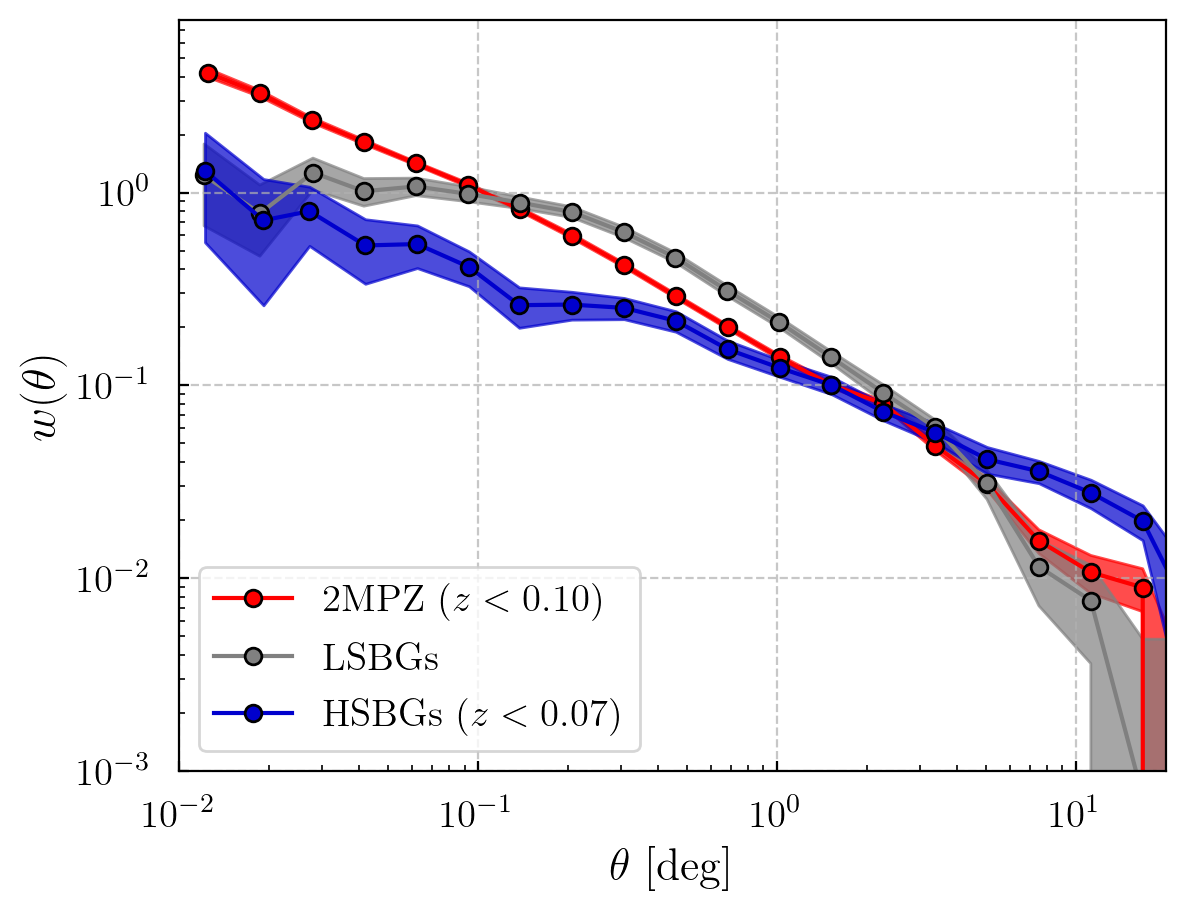

In [28]:
plt.figure(figsize = (6.,4.65))


# 2MPZ
plt.plot(r_mpz, xi_mpz, color='red',marker='o', markeredgecolor='k', label='2MPZ $(z<0.10)$')
plt.plot(r_mpz, -xi_mpz, color='red',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_mpz, xi_mpz-Errors_mpz_all, xi_mpz+Errors_mpz_all, color='red',
                 rasterized=True,alpha=0.7)


# HSB - all
#plt.plot(r_HSB_all, xi_HSB_all, color='green',marker='o', markeredgecolor='k', label='HSBGs $(z < 0.07)$')
#plt.plot(r_HSB_all, -xi_HSB_all, color='green',marker='o', markeredgecolor='k', ls=':')
#plt.fill_between(r_HSB_all, xi_HSB_all-Errors_HSB_all, xi_HSB_all+Errors_HSB_all, color='green', alpha=0.7)

# LSBG galaxies
plt.plot(r_LSBG, xi_LSBG, color='gray',marker='o', markeredgecolor='k', label='LSBGs')
plt.plot(r_LSBG, -xi_LSBG, color='gray',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_LSBG, xi_LSBG-Errors_LSBG, xi_LSBG+Errors_LSBG, color='gray',
                 rasterized=True,alpha=0.7)


# HSB - following same g mag distribution
plt.plot(r_HSB, xi_HSB, color='mediumblue',marker='o', markeredgecolor='k', label='HSBGs $(z < 0.07)$')
plt.plot(r_HSB, -xi_HSB, color='mediumblue',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_HSB, xi_HSB-Errors_HSB, xi_HSB+Errors_HSB, color='mediumblue',
                 rasterized=True,alpha=0.7)



plt.grid(ls='--',alpha=0.7)
plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ [deg]', fontsize=16)



plt.ylabel(r'$w(\theta)$', fontsize=17)
plt.legend(frameon=True, loc='lower left', fontsize=14)
plt.xlim([0.01,20]);plt.ylim(1.0e-3)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.savefig('two_point_function_HSB.pdf', dpi=300)
plt.show()

Make some plots where I impose some (the same) redshift cuts on the LSB and HSB samples and see how they differ.

More explicitly, I apply the cuts $z < 0.15, 0.1, 0.07$ in both the Low- and High- surface brightness samples.


Start with the LSB sample first:

In [27]:
# Cut z<0.15
#red_cut_lsb_1 = (z_mean_lsb>0.0)&(z_mc_lsb>0.0)&(diff_lsb<0.2)&(z_mean_lsb<0.15)

#ra_lsb_zcut_1 = ra[red_cut_lsb_1]
#dec_lsb_zcut_1 = dec[red_cut_lsb_1]

#print(len(ra_lsb_zcut_1))

In [27]:
#r_LSB_zcut_1, xi_LSB_zcut_1 = auto_correlation(ra_lsb_zcut_1, dec_lsb_zcut_1, rand_ra_pos, rand_dec_pos)
#Errors_LSB_zcut_1 = Jackknife(ra_lsb_zcut_1, dec_lsb_zcut_1, rand_ra_pos, rand_dec_pos, 100)

In [28]:
# Cut z<0.10
#red_cut_lsb_2 = (z_mean_lsb>0.0)&(z_mc_lsb>0.0)&(diff_lsb<0.2)&(z_mean_lsb<0.10)

#ra_lsb_zcut_2 = ra[red_cut_lsb_2]
#dec_lsb_zcut_2 = dec[red_cut_lsb_2]

#print(len(ra_lsb_zcut_2))

In [29]:
#r_LSB_zcut_2, xi_LSB_zcut_2 = auto_correlation(ra_lsb_zcut_2, dec_lsb_zcut_2, rand_ra_pos, rand_dec_pos)
#Errors_LSB_zcut_2 = Jackknife(ra_lsb_zcut_2, dec_lsb_zcut_2, rand_ra_pos, rand_dec_pos, 100)

In [30]:
# Cut z<0.07
#red_cut_lsb_3 = (z_mean_lsb>0.0)&(z_mc_lsb>0.0)&(diff_lsb<0.2)&(z_mean_lsb<0.07)

#ra_lsb_zcut_3 = ra[red_cut_lsb_3]
#dec_lsb_zcut_3 = dec[red_cut_lsb_3]

#print(len(ra_lsb_zcut_3))

In [31]:
#r_LSB_zcut_3, xi_LSB_zcut_3 = auto_correlation(ra_lsb_zcut_3, dec_lsb_zcut_3, rand_ra_pos, rand_dec_pos)
#Errors_LSB_zcut_3 = Jackknife(ra_lsb_zcut_3, dec_lsb_zcut_3, rand_ra_pos, rand_dec_pos, 100)

Now, let's make the similar estimation for the HSB sample. No need to do it for the case $z<0.07$, since we have already calculated that.

In [32]:
# Cut z < 0.15
# ====================================================
# ====================================================
#diff_2 = np.abs(Z_MEAN_HSB-Z_MC_HSB)
#red_cut_2 = (Z_MEAN_HSB>0.0)&(Z_MC_HSB>0.0)&(Z_MEAN_HSB<0.15)&(diff_2<0.2)

#ra_HSB_2 = ra_HSB[red_cut_2]
#dec_HSB_2 = dec_HSB[red_cut_2]
#z_HSB_2 = Z_MEAN_HSB[red_cut_2]
#z_MC_2 = Z_MC_HSB[red_cut_2]
#mag_g_2 = mag_g_HSB[red_cut_2]
#mag_i_HSB_2 = mag_i_HSB[red_cut_2] 

In [33]:
# Calculate the auto-correlation 
#r_HSB_2, xi_HSB_2 = auto_correlation(ra_HSB_2, dec_HSB_2, rand_ra_pos, rand_dec_pos)

# Calculate Jackknife errors 
#Errors_HSB_2 = Jackknife(ra_HSB_2, dec_HSB_2, rand_ra_pos, rand_dec_pos, 100)

In [34]:
# Cut z < 0.1
# ====================================================
# ====================================================
#diff_3 = np.abs(Z_MEAN_HSB-Z_MC_HSB)
#red_cut_3 = (Z_MEAN_HSB>0.0)&(Z_MC_HSB>0.0)&(Z_MEAN_HSB<0.10)&(diff_3<0.2)

#ra_HSB_3 = ra_HSB[red_cut_3]
#dec_HSB_3 = dec_HSB[red_cut_3]
#z_HSB_3 = Z_MEAN_HSB[red_cut_3]
#z_MC_3 = Z_MC_HSB[red_cut_3]
#mag_g_3 = mag_g_HSB[red_cut_3]
#mag_i_HSB_3 = mag_i_HSB[red_cut_3] 

In [35]:
# Calculate the auto-correlation 
#r_HSB_3, xi_HSB_3 = auto_correlation(ra_HSB_3, dec_HSB_3, rand_ra_pos, rand_dec_pos)

# Calculate Jackknife errors 
#Errors_HSB_3 = Jackknife(ra_HSB_3, dec_HSB_3, rand_ra_pos, rand_dec_pos, 100)

### Make plots

In [36]:
#plt.figure(figsize = (6.,4.65))


# z<0.15
# ================================================================================
# ================================================================================
#plt.plot(r_LSB_zcut_1, xi_LSB_zcut_1, color='darkorange',marker='o', markeredgecolor='k', label='LSB $(z<0.15)$')
#plt.plot(r_LSB_zcut_1, -xi_LSB_zcut_1, color='darkorange',marker='o',  markeredgecolor='k', ls=':')
#plt.fill_between(r_LSB_zcut_1, xi_LSB_zcut_1-Errors_LSB_zcut_1, xi_LSB_zcut_1+Errors_LSB_zcut_1, color='darkorange', alpha=0.7)




# z<0.10
# ================================================================================
# ================================================================================
#plt.plot(r_LSB_zcut_2, xi_LSB_zcut_2, color='mediumblue',marker='o', markeredgecolor='k', label='LSB $(z<0.10)$')
#plt.plot(r_LSB_zcut_2, -xi_LSB_zcut_2, color='mediumblue',marker='o',  markeredgecolor='k', ls=':')
#plt.fill_between(r_LSB_zcut_2, xi_LSB_zcut_2-Errors_LSB_zcut_2, xi_LSB_zcut_2+Errors_LSB_zcut_2, color='darkorange', alpha=0.7)





# z<0.10
# ================================================================================
# ================================================================================
#plt.plot(r_LSB_zcut_3, xi_LSB_zcut_3, color='red',marker='o', markeredgecolor='k', label='LSB $(z<0.07)$')
#plt.plot(r_LSB_zcut_3, -xi_LSB_zcut_3, color='red',marker='o',  markeredgecolor='k', ls=':')
#plt.fill_between(r_LSB_zcut_3, xi_LSB_zcut_3-Errors_LSB_zcut_3, xi_LSB_zcut_3+Errors_LSB_zcut_3, color='red', alpha=0.7)

# =========================================================================================
# =========================================================================================
#plt.plot(r_HSB_2, xi_HSB_2 , color='darkorange',marker='o',ls='--',  markeredgecolor='k', label='HSB $(z<0.15)$')
#plt.plot(r_HSB_2,-xi_HSB_2, color='darkorange',marker='o',  markeredgecolor='k', ls='--')
#plt.fill_between(r_HSB_2,  xi_HSB_2-Errors_HSB_2,  xi_HSB_2+Errors_HSB_2, color='darkorange', alpha=0.7)

#plt.plot(r_HSB_3, xi_HSB_3 , color='mediumblue',marker='o',ls='--', markeredgecolor='k', label='HSB $(z<0.10)$')
#plt.plot(r_HSB_3,-xi_HSB_3, color='mediumblue',marker='o',  markeredgecolor='k', ls='--')
#plt.fill_between(r_HSB_3,  xi_HSB_3-Errors_HSB_3,  xi_HSB_3+Errors_HSB_3, color='mediumblue', alpha=0.7)


#plt.plot(r_HSB_all, xi_HSB_all , color='red',marker='o',ls='--', markeredgecolor='k', label='HSB $(z<0.07)$')
#plt.plot(r_HSB_all, -xi_HSB_all, color='red',marker='o',  markeredgecolor='k', ls='--')
#plt.fill_between(r_HSB_all, xi_HSB_all-Errors_HSB_all, xi_HSB_all+Errors_HSB_all, color='red', alpha=0.7)



#plt.grid(ls='--',alpha=0.7)
#plt.xscale('log')
#plt.yscale('log', nonposy='clip')
#plt.xlabel(r'$\theta$ (degrees)', fontsize=15)



#plt.ylabel(r'$w(\theta)$', fontsize=16)
#plt.legend(frameon=True, loc='lower left', fontsize=12, ncol=2)
#plt.xlim([0.01,20]);plt.ylim(1.0e-3)
#plt.tick_params(axis='both', labelsize=14)
#plt.tight_layout()
#plt.savefig('two_point_redshift_cuts.pdf', dpi=300)
#plt.show()

## Cross-correlation analysis

### Write a function that calculates the cross correlation of two samples

In [29]:
def cross_correlation(ra_dat_1,dec_dat_1, ra_dat_2, dec_dat_2):

    # Let's make a catalogs for the randoms
    # ===============================================
    # ===============================================
    # ======================================
    rand_ra_HSB = np.random.uniform(ra_min, ra_max, 10**7)
    rand_sindec_HSB = np.random.uniform(np.sin(dec_min), np.sin(dec_max), 10**7)
    rand_dec_HSB = np.arcsin(rand_sindec_HSB)
    # ======================================
    # ======================================
    # Get the healpix indices of the randoms
    HP_ind_HSB = hp.ang2pix(4096, rand_ra_HSB/conv, rand_dec_HSB/conv, lonlat=True)
    # Keep only those with randoms for which the value of the des mask 
    # ===============================================
    # ===============================================
    # Keep local mask
    LOCAL_mask_HSB = DES_mask[HP_ind_HSB]

    # Keep those with LOCAL_mask = 1
    rand_ra_pos_HSB = rand_ra_HSB[LOCAL_mask_HSB==1]
    rand_dec_pos_HSB = rand_dec_HSB[LOCAL_mask_HSB==1]
    

    cat_rand = treecorr.Catalog(ra=rand_ra_pos, dec=rand_ra_pos, ra_units='radians', dec_units='radians')
    # Create the random catalog
    rand_HSB = treecorr.Catalog(ra=rand_ra_pos_HSB, dec=rand_dec_pos_HSB, ra_units='radians', dec_units='radians')
    # ==============================================
    # ==============================================
    cat_dat_1 = treecorr.Catalog(ra=ra_dat_1, dec=dec_dat_1, ra_units='deg', dec_units='deg')
    cat_dat_2 = treecorr.Catalog(ra=ra_dat_2, dec=dec_dat_2, ra_units='deg', dec_units='deg')
    
    # ===============================================
    # ===============================================
    dd = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
    dd.process(cat_dat_1,cat_dat_2)
    
    # ===============================================
    # ===============================================
    rr = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
    rr.process(cat_rand, rand_HSB)
    
    # Create the rd and dr (cross catalogs)
    # ===============================================================
    # ===============================================================
    # random - data 
    rd = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
    rd.process(cat_dat_1, rand_HSB)
    
    # data - random
    dr = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
    dr.process(cat_dat_2, cat_rand)
    
    
    # ==============================================================
    # ==== Calculate cross-correlation =============================
    # ==============================================================
    xi, varxi = dd.calculateXi(rr, dr, rd)
    r = np.exp(dd.meanlogr)
    sig = np.sqrt(varxi)
    
    return r, xi

### Write a function that calculates Jackknife errors of the cross-correlations

In [30]:
def Jackknife_cross(ra_dat_1,dec_dat_1, ra_dat_2, dec_dat_2, N_samples):
    """
    Inputs
    ------------------------------------------
    ra_dat_1: the ra of first catalog
    dec_dat_1: the dec first
     
    ra_dat_2: the ra of the random catalog
    dec_dat_2: the dac of the random catalog
    
    Outputs
    ------------------------------------------
    Errors in the two-point calculation across different scales
    """
    
    # First of all create array to store the results of the evaluations of 
    # the two cross_correlation functions
    Xi_vect = np.zeros([N_samples,20])
    
    # ====================================================================
    # ====================================================================
    # ========== Create randomized arrays of the data vectors ============
    # ====================================================================
    # ====================================================================
    
    # Work for the first sample first
    len_smpl_1 = len(ra_dat_1) #length of the first sample
    
    
    A = np.arange(len_smpl_1)
    #Create array where you randomly redistribute these 
    np.random.shuffle(A)
    
    #randomize the distribution of the ra, dec vectors of the data
    ra_dat_rn_1 = ra_dat_1[A]
    dec_dat_rn_1 = dec_dat_1[A]
    
    # Batch size of the first sample
    batch_1 = int(len_smpl_1/N_samples)
    
    # ====================================================================
    # Now for the second sample
    len_smpl_2 = len(ra_dat_2) #length of the first sample
    
    
    B = np.arange(len_smpl_2)
    #Create array where you randomly redistribute these 
    np.random.shuffle(B)
    
    #randomize the distribution of the ra, dec vectors of the data
    ra_dat_rn_2 = ra_dat_2[B]
    dec_dat_rn_2 = dec_dat_2[B]
    
    # Batch size of the first sample
    batch_2 = int(len_smpl_2/N_samples)
    # ===================================================================
    # ===================================================================
    
    
    #Populate the Xi_vect
    for i in range(N_samples):
        # =========================================================
        # =========================================================
        # Points to keep from the first sample 
        
        init_1 = i*batch_1 #Initial points not to keep - 1st sample
        fin_1 = (i+1)*batch_1 #final points not to keep - 1st sample
        
        # Keep data where you have excluded one batch 
        ra_dat_loc_1 = np.concatenate((ra_dat_rn_1[:init_1],ra_dat_rn_1[fin_1:]))
        dec_dat_loc_1 = np.concatenate((dec_dat_rn_1[:init_1],dec_dat_rn_1[fin_1:]))
    
        # =========================================================
        # ==========================================================
        # Points to keep from the second sample 
        
        init_2 = i*batch_2 #Initial points not to keep - 2st sample
        fin_2 = (i+1)*batch_2 #final points not to keep - 2st sample
        
        # Keep data where you have excluded one batch 
        ra_dat_loc_2 = np.concatenate((ra_dat_rn_2[:init_2],ra_dat_rn_1[fin_2:]))
        dec_dat_loc_2 = np.concatenate((dec_dat_rn_2[:init_2],dec_dat_rn_1[fin_2:]))
        
        # ===============================================================
        # ===============================================================
        
        r_loc, xi_loc = cross_correlation(ra_dat_loc_1,dec_dat_loc_1, ra_dat_loc_2, dec_dat_loc_2)
        
        Xi_vect[i,:] = xi_loc
        
    # ======================================================================
    # ======================================================================
    # Define vector to store the errors
    Err_vect = np.zeros(20)
    
    for i in range(20):
        
        Xi_i = Xi_vect[:,i]
        mean_Xi_i = np.mean(Xi_i)
        diff_sq = (Xi_i - mean_Xi_i)**2.0
        sig_sq = ((N_samples - 1.0)/N_samples)*np.sum(diff_sq)

        Err_vect[i] = np.sqrt(sig_sq)
    
    return Err_vect
    

In [31]:
# Calculate cross correlations now
# =========================================================
# First, cross-correlation between LSB and HSB
r_1, cross_1 = cross_correlation(ra,dec,ra_redist,dec_redist)
# Cross-correlation between LSB and 2mpz
r_2, cross_2 = cross_correlation(ra,dec,ra_mpz_in,dec_mpz_in)
# Cross-correlation between HSB and 2mpz
r_3, cross_3 = cross_correlation(ra_redist,dec_redist,ra_mpz_in,dec_mpz_in)

In [32]:
# Calculate errors in the cross correlations now
# =========================================================
# First, for the cross-correlation between LSB and HSB
Errors_cross_1 = Jackknife_cross(ra,dec,ra_redist,dec_redist,40)
# For the cross-correlation between LSB and 2mpz
Errors_cross_2 = Jackknife_cross(ra,dec,ra_mpz_in,dec_mpz_in,40)
# For the cross-correlation between HSB and 2mpz
Errors_cross_3 = Jackknife_cross(ra_redist,dec_redist,ra_mpz_in,dec_mpz_in,40)

In [33]:
#r_4, cross_4 = cross_correlation(ra_lsb_zcut_2,dec_lsb_zcut_2,ra_HSB_3,dec_HSB_3)

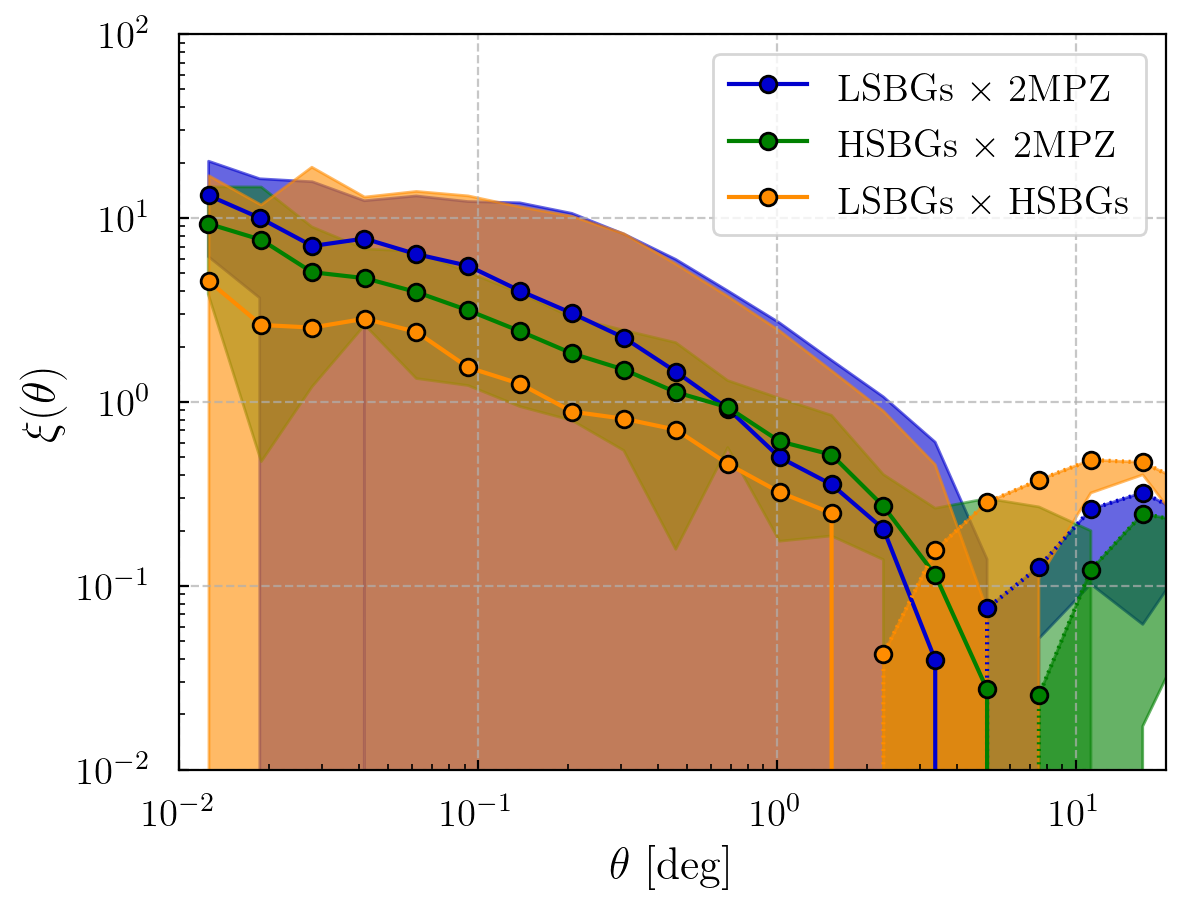

In [34]:
plt.figure(figsize = (6.,4.65))










plt.plot(r_2, cross_2 , color='mediumblue',marker='o', markeredgecolor='k', label=r'LSBGs $\times$ 2MPZ')
plt.plot(r_2,-cross_2, color='mediumblue',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_2, cross_2-Errors_cross_2, cross_2+Errors_cross_2, color='mediumblue',
                 rasterized=True,alpha=0.6)
plt.fill_between(r_2, -cross_2-Errors_cross_2, -cross_2, color='mediumblue',
                 rasterized=True,alpha=0.6)
# ================================================================================
# ================================================================================

plt.plot(r_3, cross_3 , color='green',marker='o', markeredgecolor='k', label=r'HSBGs $\times$ 2MPZ')
plt.plot(r_3,-cross_3, color='green',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_3, cross_3-Errors_cross_3, cross_3+Errors_cross_3, color='green',
                 rasterized=True,alpha=0.5)
plt.fill_between(r_3, -cross_3-Errors_cross_3, -cross_3, color='green',
                 rasterized=True,alpha=0.6)





plt.plot(r_1,cross_1, color='darkorange',marker='o', markeredgecolor='k', label=r'LSBGs $\times$ HSBGs')
plt.plot(r_1, -cross_1, color='darkorange',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_1, cross_1-Errors_cross_1, cross_1+Errors_cross_1, color='darkorange',
                 rasterized=True, alpha=0.6)
plt.fill_between(r_1, -cross_1-Errors_cross_1, -cross_1, color='darkorange',
                 rasterized=True, alpha=0.6)




plt.grid(ls='--',alpha=0.7)
plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ [deg]', fontsize=16)



plt.ylabel(r'$\xi(\theta)$', fontsize=17)
plt.legend(frameon=True, loc='upper right', fontsize=14)
plt.xlim([0.01,20]);plt.ylim(1.0e-2,100)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.savefig('Cross_correlations.pdf', dpi=300)
plt.show()

### Correlation coefficient and its error


Here we calculate the (square) of the correlation coefficient:

\begin{equation}
\rho^2(\theta) = \frac{\xi^2(\theta)}{w_1(\theta) w_2(\theta)}
\end{equation}

The error on the $\rho^2(\theta)$ can be estimated as:


\begin{equation}
\delta \rho^2 = \rho^2 \sqrt{4\left(\frac{\delta \xi}{\xi}\right)^2 +\left(\frac{\delta w_1}{w_1}\right)^2+ \left(\frac{\delta w_2}{w_2}\right)^2}
\end{equation}

In [35]:
rho_1_sq = np.abs((cross_1**2.0)/(xi_LSBG*xi_HSB))
rho_2_sq = np.abs((cross_2**2.0)/(xi_LSBG*xi_mpz))
rho_3_sq = np.abs((cross_3**2.0)/(xi_HSB*xi_mpz))

In [36]:
delta_rho_1 = rho_1_sq*np.sqrt(4*(Errors_cross_1/cross_1)**2.0+(Errors_LSBG/xi_LSBG)**2.0+(Errors_HSB/xi_HSB)**2.0)
delta_rho_2 = rho_2_sq*np.sqrt(4*(Errors_cross_2/cross_2)**2.0+(Errors_LSBG/xi_LSBG)**2.0+(Errors_mpz_all/xi_mpz)**2.0)
delta_rho_3 = rho_3_sq*np.sqrt(4*(Errors_cross_3/cross_3)**2.0+(Errors_HSB/xi_HSB)**2.0+(Errors_mpz_all/xi_mpz)**2.0)

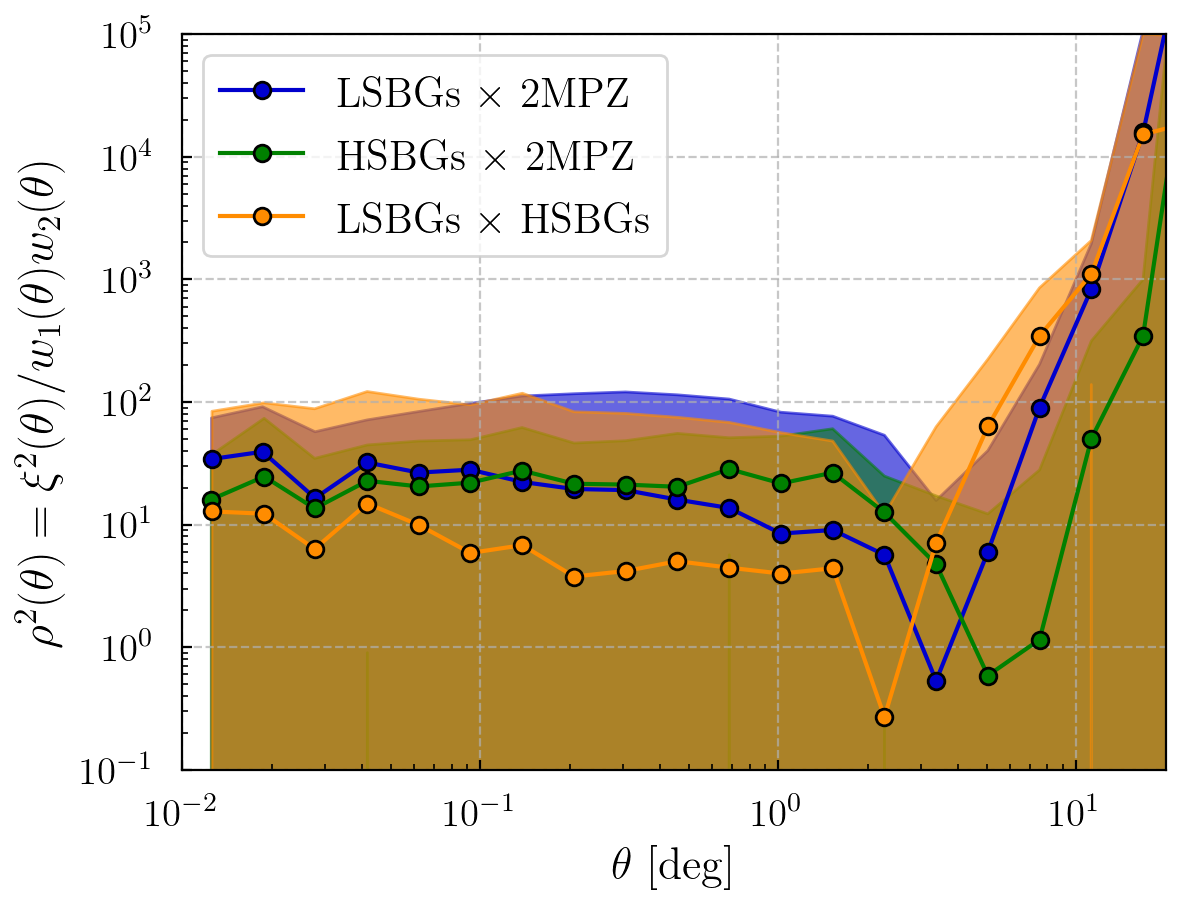

In [37]:
plt.figure(figsize = (6.,4.65))


plt.plot(r_2, rho_2_sq , color='mediumblue',marker='o', markeredgecolor='k', label=r'LSBGs $\times$ 2MPZ')
plt.fill_between(r_2, rho_2_sq-delta_rho_2, rho_2_sq+delta_rho_2, color='mediumblue',
                 rasterized=True,alpha=0.6)

plt.plot(r_3, rho_3_sq , color='green',marker='o', markeredgecolor='k', label=r'HSBGs $\times$ 2MPZ')
plt.fill_between(r_3, rho_3_sq-delta_rho_3, rho_3_sq+delta_rho_3, color='green',
                 rasterized=True,alpha=0.55)

plt.plot(r_1,rho_1_sq, color='darkorange',marker='o', markeredgecolor='k', label=r'LSBGs $\times$ HSBGs')
plt.fill_between(r_1, rho_1_sq-delta_rho_1, rho_1_sq+delta_rho_1, color='darkorange',
                 rasterized=True,alpha=0.6)




# ================================================================================
# ================================================================================



plt.grid(ls='--',alpha=0.7)
plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ [deg]', fontsize=16)



plt.ylabel(r'$\rho^2(\theta)=\xi^2(\theta)/w_1(\theta)w_2(\theta)$', fontsize=17)
plt.legend(frameon=True, loc='upper left', fontsize=15)
plt.xlim([0.01,20]);plt.ylim(1.0e-1,1e5)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.savefig('correlation_coefficient.pdf', dpi=300)
plt.show()

In [38]:
# Open and read the HSB galaxies catalog
#mpz_2 = fits.open('2MPZ.fits')
#print mpz_2[1].header.keys